### Import libraries

In [11]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import pydot

### Connect to database

In [2]:
database = 'llm-apps/chinook.db'

In [3]:
file_size = os.path.getsize(database)
print(f"Database file size: {file_size} bytes")

Database file size: 1067008 bytes


In [4]:
if os.path.exists(database):
    print("Database exists")
else:
    print("Database does not exist")

Database exists


In [5]:
try:
    conn = sqlite3.connect(database)
    print("Connection successful")
except sqlite3.Error as e:
    print(f"Error connecting to database: {e}")
    conn = None

Connection successful


Take a look at which tables are available.

In [6]:
conn = sqlite3.connect(database)
## importing tables
tables = pd.read_sql("""SELECT name, type
                        FROM sqlite_master
                         WHERE type IN ("table", "view");""", conn)

In [7]:
tables.head(10)

,name,type
0,Album,table
1,Artist,table
2,Customer,table
3,Employee,table
4,Genre,table
5,Invoice,table
6,InvoiceLine,table
7,MediaType,table
8,Playlist,table
9,PlaylistTrack,table


Graph the table structure using pydot.

In [8]:
tables_query = """
SELECT name
FROM sqlite_master
WHERE type='table';
"""

In [9]:
# Get list of tables
tables = pd.read_sql(tables_query, conn)

In [20]:
# Create the path to save the diagrams
save_path = os.path.expanduser('~/Documents/llm-apps/structured-data/database_structure_with_nodes.png')

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [21]:
# Create a graph
graph = pydot.Dot(graph_type='digraph')

# Add nodes for each table
for table in tables['name']:
    columns_query = f"PRAGMA table_info({table});"
    columns = pd.read_sql(columns_query, conn)

    label = f"{table}\n" + "\n".join(columns['name'])
    node = pydot.Node(table, label=label, shape='box')
    graph.add_node(node)

# Add edges for foreign key relationships
for table in tables['name']:
    foreign_keys_query = f"PRAGMA foreign_key_list({table});"
    foreign_keys = pd.read_sql(foreign_keys_query, conn)

    for _, fk in foreign_keys.iterrows():
        edge = pydot.Edge(fk['table'], table)
        graph.add_edge(edge)

# Save the graph to a file
graph.write_png('database_structure_with_nodes.png')

In [22]:
# Save the graph 
graph.write_png(save_path)

print(f"ER diagram saved to {save_path}")

ER diagram saved to /Users/curtispond/Documents/llm-apps/structured-data/database_structure_with_nodes.png


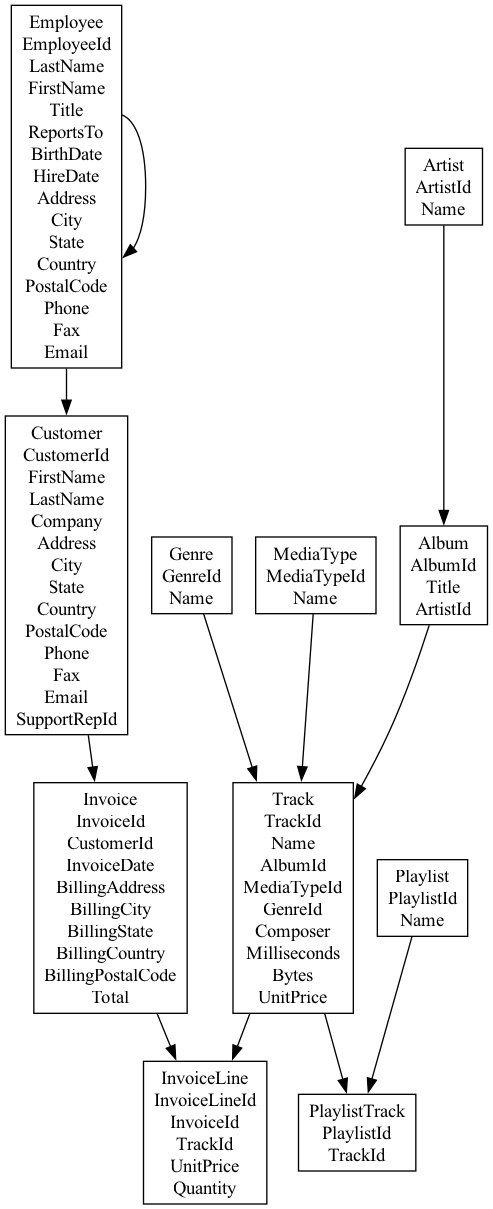

In [23]:
from IPython.display import Image, display
display(Image(filename=save_path))

### Inspect the data

In [ ]:
pd.read_sql("SELECT * FROM Customer LIMIT 5;", conn)

In [ ]:
pd.read_sql("Select * from Invoice LIMIT 5;", conn)

Take a look at the top 5 countries per album sale

In [ ]:
pd.read_sql("""
SELECT c.Country AS Country, SUM(i.Total) AS Sales
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
""", conn)

How many tracks are there per genre?

In [ ]:
sql = """
SELECT g.Name AS Genre, COUNT(t.TrackId) AS Tracks
FROM Genre g
JOIN Track t ON g.GenreId = t.GenreId
GROUP BY Genre
ORDER BY Tracks DESC;
"""

In [ ]:
# Read the data into a dataframe
data = pd.read_sql(sql, conn)
# Plot the data as a bar chart
plt.bar(data.Genre, data.Tracks)
plt.title("Number of Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Tracks")
plt.xticks(rotation=90)
plt.show()